In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.bag as db
import tqdm 

from distributed import Client
from dask_jobqueue import SLURMCluster
from IPython.display import display

import os
from glob import glob

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='256GB', cores=8, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://127.0.0.1:36145 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 34.36 GB


In [3]:
os.chdir('/scratch/work/courses/DSGA1004-2021/movielens/ml-latest-small')

In [4]:
# Import the ratings dataset
ratings_df = pd.read_csv('ratings.csv').sort_values(by="timestamp").reset_index(drop=True)
print("This dataset contains {} rows and {} columns.".format(ratings_df.shape[0], ratings_df.shape[1]))
ratings_df.head()

This dataset contains 100836 rows and 4 columns.


,userId,movieId,rating,timestamp
0,429,595,5.0,828124615
1,429,588,5.0,828124615
2,429,590,5.0,828124615
3,429,592,5.0,828124615
4,429,432,3.0,828124615


In [5]:
# Count the number of ratings for each movie
num_ratings_per_movie = ratings_df.groupby("movieId").count()["rating"]

# Only keep movies with at least 5 ratings (e.g. we don't want to treat a movie that was rated 5 stars by too few people to be considered popular)
ratings_df = ratings_df.join(num_ratings_per_movie, on = "movieId", rsuffix="_count")
ratings_df = ratings_df[ratings_df["rating_count"] >= 5]
ratings_df.drop(columns=["rating_count"], inplace=True)

# Compute how many times each movie has been rated
print(ratings_df["movieId"].value_counts(ascending=True))

458         5
112788      5
40414       5
6832        5
3724        5
         ... 
2571      278
593       279
296       307
318       317
356       329
Name: movieId, Length: 3650, dtype: int64


## Training-validation-test split

Split each user's data into training-validation-test set. First, we will separate 20% of the users to be part of the test set. Then for each remaining user, use 80% of their ratings for training and 20% for validation. We do this so that our recommender system generalizes across different kinds of users.

In [6]:
train_users = np.random.choice(ratings_df['userId'].unique(), int(len(ratings_df['userId'].unique()) * 0.8), replace=False)

train_val_df = ratings_df[ratings_df['userId'].isin(train_users)]
test_df = ratings_df[~ratings_df['userId'].isin(train_users)]

In [7]:
# For each user, compute the number of ratings they submitted
num_ratings_per_user = train_val_df.groupby('userId').count()['rating']

In [8]:
# Create training and validation sets for each user
train_df, val_df = pd.DataFrame(), pd.DataFrame()

for userId, num_ratings in tqdm.tqdm_notebook(list(zip(num_ratings_per_user.index, num_ratings_per_user))):
    # Get all the ratings for this user
    user_ratings = train_val_df[train_val_df['userId'] == userId].reset_index(drop=True)
    
    # Make the first 80% of this user's ratings the training set
    index_train = int(0.8*num_ratings)
    user_train = user_ratings.loc[:index_train-1, :]
    
    # Make the other 20% of this user's ratings the validation set
    user_val = user_ratings.loc[index_train:, :]
    
    # Add this user's individual training and validation sets to the unified training and
    # validation sets, respectively
    train_df = pd.concat([train_df, user_train], axis=0)
    val_df = pd.concat([val_df, user_val], axis=0)

<ipython-input-8-d7ab56e65984>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, num_ratings in tqdm.tqdm_notebook(list(zip(num_ratings_per_user.index, num_ratings_per_user))):


  0%|          | 0/488 [00:00<?, ?it/s]

In [9]:
# Sanity check (these should match)
print(len(ratings_df))
print(sum([len(train_df), len(val_df), len(test_df)]))

90274
90274


# Baseline Model

Compute the mean rating of each movie by grouping by movieId, and aggregating by mean. Note that we don't want to explicitly compute the utility matrix, because doing so will take a very long time, and the resulting matrix will be very large and take up a lot of memory.

We compute the 100 highest mean-rated movies from the training set. We will recommend these 100 movies to every single user in the validation set.

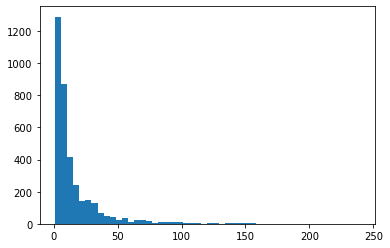

In [10]:
plt.hist(train_df.groupby('movieId').count()['userId'], bins=50)
plt.show()

In [11]:
# Compute mean ratings
mean_ratings = train_df[["movieId", "rating"]].groupby("movieId").mean()["rating"].sort_values(ascending=False)

# We need to recommend to everyone in the validation set the 100 movies that we learned from the training set
R_i = np.array(mean_ratings.head(100).index)
print(R_i)

[187595    891 102033  54881  31364  26084 130490  87529 177593   6460
    213   1178    232   2360  67997 120635  98491   3925 106642    942
  83803   7669   2732     82   1927   1280   1204    905   3435   1217
  55363  44694   8827  33154   1177  73323  78637  26131  82169    994
   3470   8128    334    951   1354   1041   1633   2202   2239   2357
   2436    627   3019   3182   3201   3468   3469   4334   3265   3811
 158966 187593 113378 157699   3030    162   7156   3429    971   3983
    898   1104   3200   2648   3814   7132   1243  85342   2351   3152
  31410   5690    922    933    318  27803   2159    945   3153 168252
   1235    965    930  53129   1361  55814   1951   3334  47999    750]


## Recommendation Algorithm

In [12]:
# Number of users in the validation data
users = val_df['userId'].unique()
n_users = len(users)

# Number of movies that we recommend to each user
n_recs = 100

# Initialize array of relevances
rel_D = pd.DataFrame(np.empty(shape=(n_users, n_recs)), index=users, columns=R_i)

For faster computation, we'd like to create a list of arrays `D`, where each element of the list (`D[i]`) is an array containing the validation data of the highest-rated movies by this user (from highest to lowest rating). But to do this, we need to sort the entire validation data from highest to lowest rating, so that `.get_group` will return a movies array sorted from highest to lowest rating as well.

In [13]:
val_df = val_df.sort_values("rating", ascending=False)
val_df_group = val_df.groupby("userId")
D = list(map(lambda user: val_df_group.get_group(user)["movieId"].values[0:100], users))

# For each user, compute relevance
# rel_D[u, m] = 1 if recommended movie m is relevant to user u and 0 otherwise
rel_D[:] = np.row_stack(list(map(lambda D_i: np.isin(R_i, D_i).astype(int), D)))
rel_D

,187595,891,102033,54881,31364,26084,130490,87529,177593,6460,...,1235,965,930,53129,1361,55814,1951,3334,47999,750
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Compute precision at k=100
k = 100
precision = np.mean(np.sum(rel_D, axis=1) / k)
print("Precision: {}%".format(np.round(precision*100, 5)))

Precision: 0.48156%


In [15]:
# Compute MAP
j_plus_1 = np.arange(1, 101)
inner_sum = np.sum(rel_D / j_plus_1, axis=1)
N = np.fromiter(map(lambda D_i: D_i.size, D), dtype=int) # an array where N[i] = number of movies rated by user i
MAP = np.mean(1/N * inner_sum)
print("The MAP is: {}%".format(np.round(MAP*100, 5)))

The MAP is: 0.0648%


### Questions

* Should we be constructing our baseline model using the whole dataset or only the training set?

### Comments
* Is it ok to use training set + validation set to train our baseline model? Would the scores be comparable to the more advanced model, which we train only on the training set?

### To-Do
* Currently we only keep movies with at least 5 ratings - we should probably change this number depending on the size of the dataset